In [20]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
H, W = 224, 224
BATCH_SIZE = 32

In [4]:
image_paths = []
image_labels = []
normal_count = scc_count = 0


# dataset_dir = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
dataset_dir = './multi-cancer'
for dirname, _, filenames in os.walk(os.path.join(dataset_dir, 'Oral Cancer')):
    for filename in filenames:
        if "bak" in filename: 
            continue    #Ignore all images ending with .bak
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'normal' in filename:
            image_labels.append(0)
            normal_count += 1
        else:
            image_labels.append(1)
            scc_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Image count:", len(image_paths))
print("Normal count:", normal_count)
print("SCC count:", scc_count)
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['./multi-cancer\\Oral Cancer\\oral_normal\\oral_normal_3772.jpg', './multi-cancer\\Oral Cancer\\oral_scc\\oral_scc_1673.jpg', './multi-cancer\\Oral Cancer\\oral_scc\\oral_scc_2262.jpg', './multi-cancer\\Oral Cancer\\oral_normal\\oral_normal_0761.jpg', './multi-cancer\\Oral Cancer\\oral_normal\\oral_normal_3780.jpg'] 

[0, 1, 1, 0, 0] 

Image count: 10000
Normal count: 5000
SCC count: 5000
Image size: (512, 512)
Image mode: RGB


In [5]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7000
Validation size: 1500
Testing size: 1500


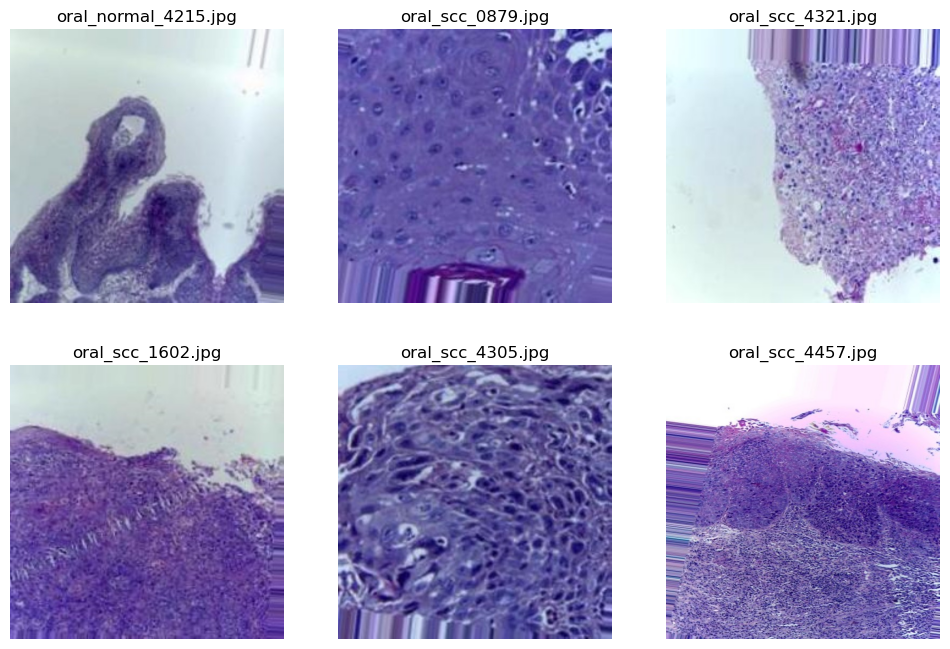

In [6]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [7]:
# Calculate Mean and Standard Deviation of the training set
# transform = transforms.Compose([
#     transforms.Resize((H, W)),
#     transforms.ToTensor()
# ])

# mean = 0.
# std = 0.
# n = 0

# for path in tqdm(train_paths):
#     img = Image.open(path).convert('RGB')
#     img = transform(img)  # shape: [3, H, W]
#     mean += img.mean(dim=[1,2])
#     std += img.std(dim=[1,2])
#     n += 1

# mean /= n
# std /= n

mean = torch.tensor([0.5528, 0.5140, 0.7288])
std = torch.tensor([0.1615, 0.1922, 0.1221])

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.5528, 0.5140, 0.7288])
Std: tensor([0.1615, 0.1922, 0.1221])


In [8]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]) 

In [9]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [11]:
@torch.no_grad()
def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Validating", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples


In [12]:
def save_checkpoint(model, optimizer, epoch, val_acc, train_losses, val_losses, save_path):
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "val_acc": val_acc,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, save_path)

    print(f"[Checkpoint Saved] epoch={epoch}, val_acc={val_acc:.4f} → {save_path}")

def load_checkpoint(model, optimizer, path, device):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No checkpoint found at '{path}'")

    ckpt = torch.load(path, map_location=device)

    model.load_state_dict(ckpt["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

    start_epoch = ckpt.get("epoch", 0)
    best_val_acc = ckpt.get("val_acc", 0.0)

    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])

    print(f"[Checkpoint Loaded] epoch={start_epoch}, best_val_acc={best_val_acc:.4f}")
    return model, optimizer, start_epoch, best_val_acc, train_losses, val_losses

In [13]:
@torch.no_grad()
def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    print(f"\nTest Accuracy: {acc:.4f}")

    if class_names is None:
        class_names = ["normal", "SCC"]

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

### Phase 1: Train with frozen backbone

In [14]:
num_classes = 2

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes) # type: ignore

for param in model.features.parameters():
    param.requires_grad = False

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [15]:
TRAIN_PHASE1 = True

num_epochs = 10
patience = 5
best_val_acc = 0.0

checkpoint_dir = Path("checkpoints/phase1")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE1:
    train_losses = []
    val_losses = []
    start_epoch = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Epoch 1/10] Train Loss: 0.5011, Acc: 0.7533 | Val Loss: 0.4186, Acc: 0.8013
[Checkpoint Saved] epoch=1, val_acc=0.8013 → checkpoints\phase1\best_model.pth


[Epoch 2/10] Train Loss: 0.4253, Acc: 0.8040 | Val Loss: 0.3909, Acc: 0.8200
[Checkpoint Saved] epoch=2, val_acc=0.8200 → checkpoints\phase1\best_model.pth


[Epoch 3/10] Train Loss: 0.4179, Acc: 0.8041 | Val Loss: 0.3720, Acc: 0.8233
[Checkpoint Saved] epoch=3, val_acc=0.8233 → checkpoints\phase1\best_model.pth


[Epoch 4/10] Train Loss: 0.4116, Acc: 0.8119 | Val Loss: 0.3649, Acc: 0.8413
[Checkpoint Saved] epoch=4, val_acc=0.8413 → checkpoints\phase1\best_model.pth


[Epoch 5/10] Train Loss: 0.3910, Acc: 0.8224 | Val Loss: 0.3453, Acc: 0.8473
[Checkpoint Saved] epoch=5, val_acc=0.8473 → checkpoints\phase1\best_model.pth


[Epoch 6/10] Train Loss: 0.3984, Acc: 0.8217 | Val Loss: 0.3378, Acc: 0.8567
[Checkpoint Saved] epoch=6, val_acc=0.8567 → checkpoints\phase1\best_model.pth


[Epoch 7/10] Train Loss: 0.4097, Acc: 0.8091 | Val Loss: 0.3342, Acc: 0.8527


[Epoch 8/10] Train Loss: 0.3952, Acc: 0.8157 | Val Loss: 0.3356, Acc: 0.8513


[Epoch 9/10] Train Loss: 0.3905, Acc: 0.8213 | Val Loss: 0.3358, Acc: 0.8453


[Epoch 10/10] Train Loss: 0.4029, Acc: 0.8191 | Val Loss: 0.3390, Acc: 0.8393


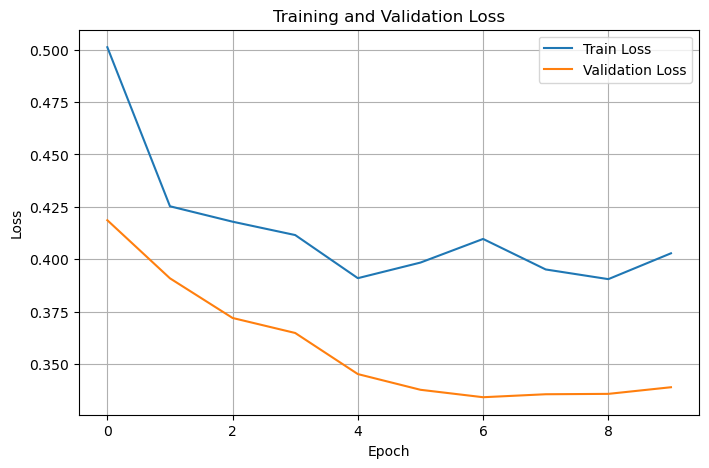

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Phase 2: Fine-tune the entire model

In [21]:
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True) 

In [22]:
for param in model.features.parameters():
    param.requires_grad = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [23]:
TRAIN_PHASE2 = True
num_epochs = 20

checkpoint_dir = Path("checkpoints/phase2")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE2:
    train_losses = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, combined_loader, optimizer, criterion, device)
        test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"[Phase2 Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    save_checkpoint(model, optimizer, num_epochs, test_acc, train_losses, test_losses, checkpoint_path)
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, test_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Phase2 Epoch 1/20] Train Loss: 0.2541, Acc: 0.8919 | Test Loss: 0.0978, Acc: 0.9627


[Phase2 Epoch 2/20] Train Loss: 0.1104, Acc: 0.9575 | Test Loss: 0.0545, Acc: 0.9800


[Phase2 Epoch 3/20] Train Loss: 0.0722, Acc: 0.9714 | Test Loss: 0.0463, Acc: 0.9840


[Phase2 Epoch 4/20] Train Loss: 0.0590, Acc: 0.9787 | Test Loss: 0.0412, Acc: 0.9840


[Phase2 Epoch 5/20] Train Loss: 0.0429, Acc: 0.9836 | Test Loss: 0.0385, Acc: 0.9853


[Phase2 Epoch 6/20] Train Loss: 0.0346, Acc: 0.9868 | Test Loss: 0.0445, Acc: 0.9840


[Phase2 Epoch 7/20] Train Loss: 0.0342, Acc: 0.9874 | Test Loss: 0.0421, Acc: 0.9893


[Phase2 Epoch 8/20] Train Loss: 0.0303, Acc: 0.9886 | Test Loss: 0.0375, Acc: 0.9887


[Phase2 Epoch 9/20] Train Loss: 0.0253, Acc: 0.9901 | Test Loss: 0.0373, Acc: 0.9853


[Phase2 Epoch 10/20] Train Loss: 0.0291, Acc: 0.9893 | Test Loss: 0.0414, Acc: 0.9867


[Phase2 Epoch 11/20] Train Loss: 0.0250, Acc: 0.9914 | Test Loss: 0.0306, Acc: 0.9893


[Phase2 Epoch 12/20] Train Loss: 0.0257, Acc: 0.9900 | Test Loss: 0.0418, Acc: 0.9847


[Phase2 Epoch 13/20] Train Loss: 0.0218, Acc: 0.9907 | Test Loss: 0.0382, Acc: 0.9880


[Phase2 Epoch 14/20] Train Loss: 0.0230, Acc: 0.9899 | Test Loss: 0.0388, Acc: 0.9860


[Phase2 Epoch 15/20] Train Loss: 0.0190, Acc: 0.9932 | Test Loss: 0.0446, Acc: 0.9853


[Phase2 Epoch 16/20] Train Loss: 0.0172, Acc: 0.9932 | Test Loss: 0.0431, Acc: 0.9853


[Phase2 Epoch 17/20] Train Loss: 0.0222, Acc: 0.9919 | Test Loss: 0.0378, Acc: 0.9887


[Phase2 Epoch 18/20] Train Loss: 0.0169, Acc: 0.9935 | Test Loss: 0.0376, Acc: 0.9867


[Phase2 Epoch 19/20] Train Loss: 0.0161, Acc: 0.9942 | Test Loss: 0.0356, Acc: 0.9873


[Phase2 Epoch 20/20] Train Loss: 0.0149, Acc: 0.9938 | Test Loss: 0.0479, Acc: 0.9867
[Checkpoint Saved] epoch=20, val_acc=0.9867 → checkpoints\phase2\best_model.pth
[Checkpoint Saved] epoch=20, val_acc=0.9867 → checkpoints\phase2\best_model.pth


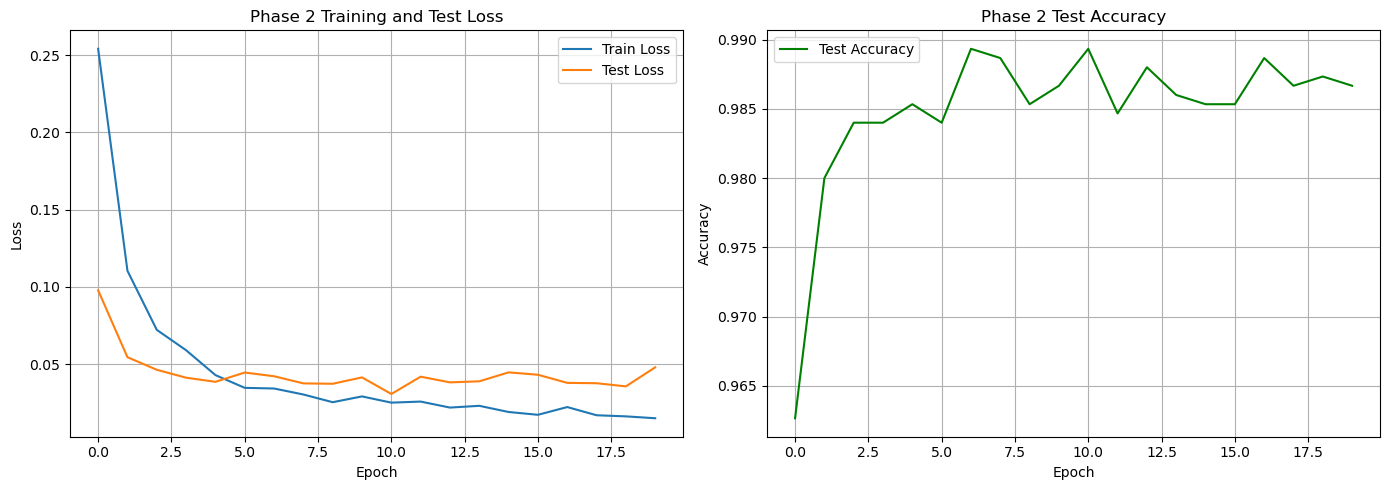

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_losses, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Phase 2 Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(test_accs, label='Test Accuracy', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Phase 2 Test Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Testing: 100%|██████████| 47/47 [00:09<00:00,  5.01it/s]




Test Accuracy: 0.9867

Classification Report:
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       750
         SCC       0.99      0.99      0.99       750

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



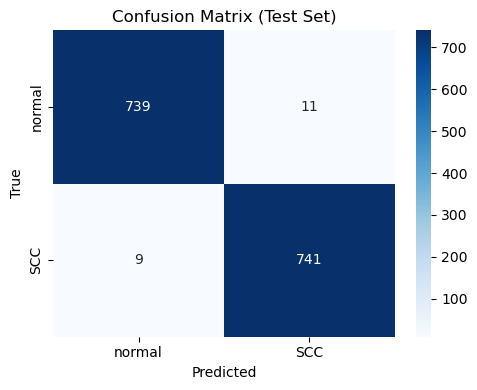

In [25]:
evaluate_on_test(model, test_loader, device, class_names=["normal", "SCC"])